Solar Panel Adoption Prediction with PU Learning
--------------------------------------------------
Training set: 41909 samples with 7407 positive examples
Testing set: 17962 samples with 3174 positive examples

Training PU Learner...
Training on 41909 samples with 7407 positive examples
Using 7 features: ['lckpre_max', 'lckumw_max', 'lceemob_ma', 'lcbjkl_mea', 'lcalter_mi']...

Evaluating model...
AUC: 0.602
Average Precision: 0.238


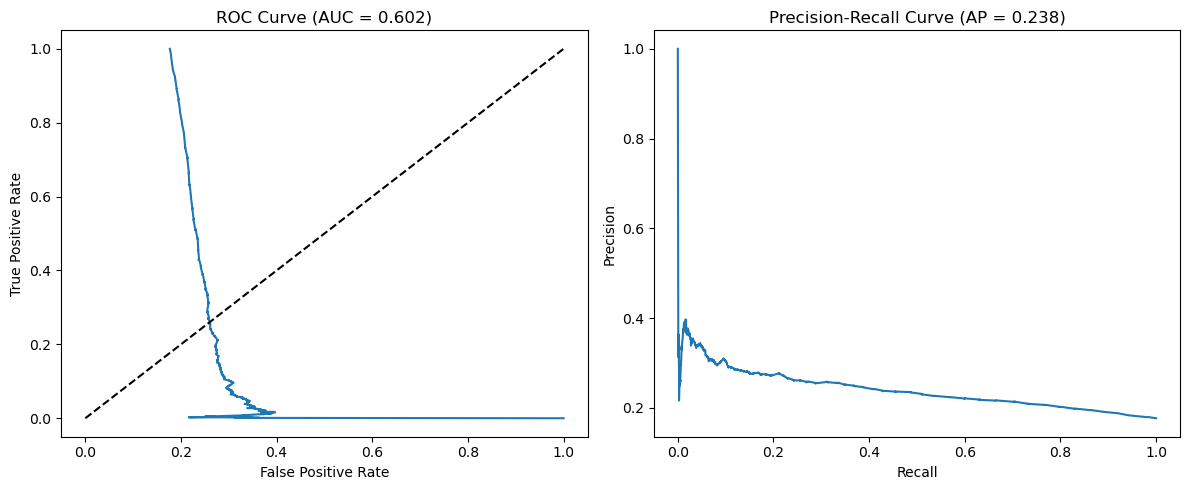


Feature Importance:
      feature  importance
6  kk_idx_mea    0.433121
3  lcbjkl_mea    0.112988
2  lceemob_ma    0.111008
1  lckumw_max    0.108948
0  lckpre_max    0.102596
4  lcalter_mi    0.068970
5  lcgchar_ma    0.062370

Generating predictions for all houses...

Top 5 houses by adoption probability:
       adoption_probability  solar
77469                   1.0      1
79092                   1.0      1
79204                   1.0      1
79145                   1.0      1
79203                   1.0      1


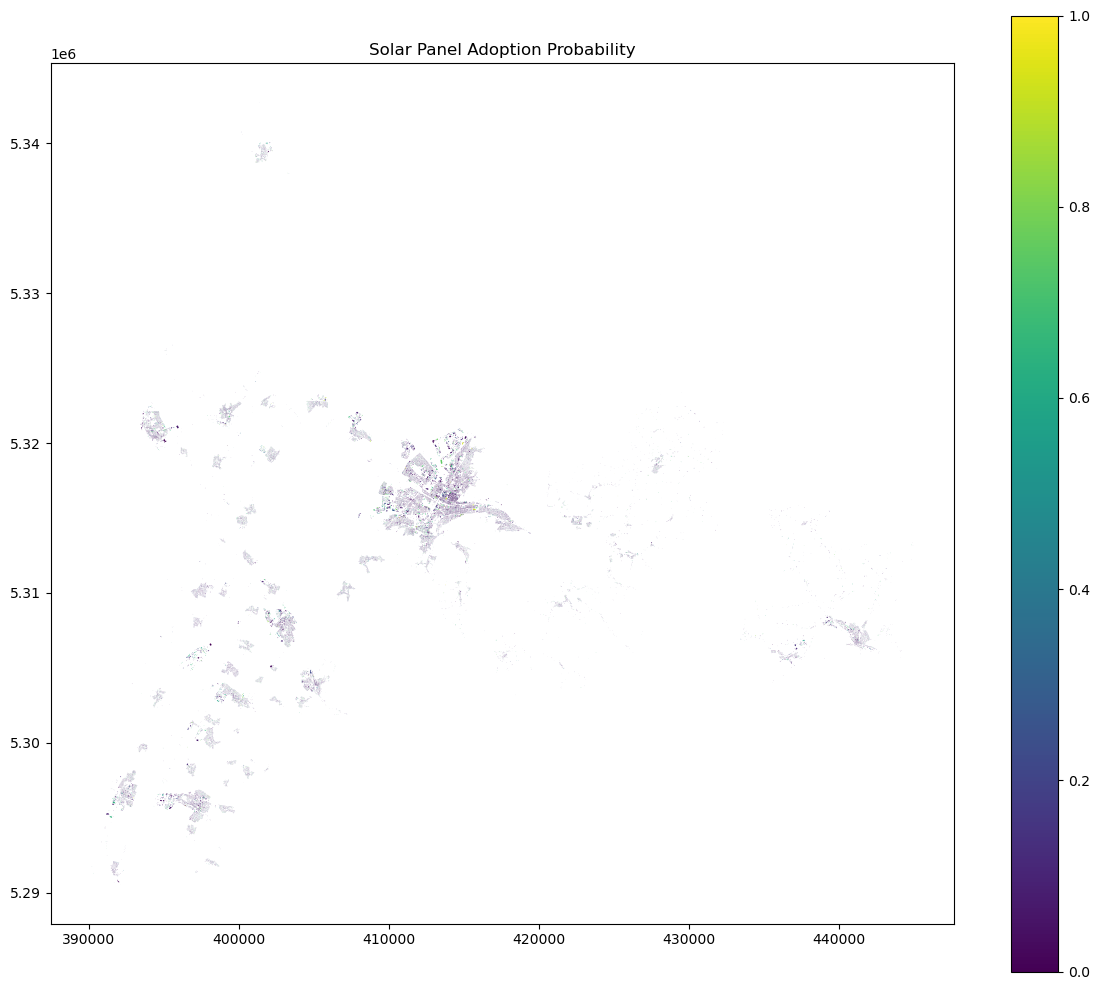

C:\Users\peers\AppData\Local\Temp\ipykernel_16796\2671057678.py:353: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  houses_with_predictions.to_file('houses_with_solar_predictions05.shp')
c:\Users\peers\.conda\envs\hack\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'adoption_probability' to 'adoption_p'
  ogr_write(
c:\Users\peers\.conda\envs\hack\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'predicted_adoption' to 'predicted_'
  ogr_write(


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from copy import deepcopy

class PULearner:
    """
    PU Learning implementation for solar panel adoption prediction.
    
    This implementation is specifically adapted for GeoPandas DataFrames,
    preserving geometry information while handling the numerical features
    for model training.
    """
    def __init__(self, base_classifier=None, c=0.3):
        """
        Initialize PU Learner
        
        Parameters:
        - base_classifier: The classifier to use (defaults to RandomForest)
        - c: The assumed fraction of positives in the unlabeled set
           (can be estimated or tuned as hyperparameter)
        """
        self.base_classifier = base_classifier or RandomForestClassifier(n_estimators=100)
        self.c = c
        self.fitted = False
        self.feature_columns = None
        self.target_column = None
        self.geometry_column = None
    
    def _clone_classifier(self, estimator):
        """Clone an estimator"""
        if hasattr(estimator, 'get_params'):
            return type(estimator)(**estimator.get_params())
        return type(estimator)()
    
    def fit(self, gdf, target_column, feature_columns=None, geometry_column='geometry'):
        """
        Train the PU learning model
        
        Parameters:
        - gdf: GeoPandas DataFrame with houses data
        - target_column: Column name for the target (1=has panels, 0=no panels/unlabeled) 
        - feature_columns: List of column names to use as features (if None, will use all numeric columns)
        - geometry_column: Name of the geometry column (default='geometry')
        
        Returns:
        - self: Trained model
        """
        self.target_column = target_column
        self.geometry_column = geometry_column
        
        # Store original gdf for later reference
        self.original_gdf = gdf.copy()
        
        # Select feature columns (excluding target and geometry)
        if feature_columns is None:
            # Use all numeric columns except target
            non_feature_cols = [target_column, geometry_column]
            numeric_cols = gdf.select_dtypes(include=['number']).columns.tolist()
            self.feature_columns = [col for col in numeric_cols if col not in non_feature_cols]
        else:
            self.feature_columns = feature_columns
        
        # Extract features and target
        X = gdf[self.feature_columns].values
        y = gdf[target_column].values
        
        # Check if we have positive examples
        if np.sum(y) == 0:
            raise ValueError("No positive examples found in the dataset. Cannot train PU model.")
        
        print(f"Training on {len(X)} samples with {np.sum(y)} positive examples")
        print(f"Using {len(self.feature_columns)} features: {self.feature_columns[:5]}...")
        
        # Step 1: Train classifier to distinguish observed positives from unlabeled
        self.classifier1 = self._clone_classifier(self.base_classifier)
        self.classifier1.fit(X, y)
        
        # Get probabilities from first classifier
        prob_s = self.classifier1.predict_proba(X)[:, 1]
        
        # Calculate weights for unlabeled samples
        unlabeled_idx = np.where(y == 0)[0]
        positive_idx = np.where(y == 1)[0]
        
        # Create weights, default 1.0 for positive examples
        sample_weights = np.ones(len(X))
        
        # For unlabeled examples, weight by estimated probability of being positive
        for i in unlabeled_idx:
            # Add small epsilon to avoid division by zero
            sample_weights[i] = max(0, self.c * prob_s[i] / (1 - prob_s[i] + 1e-5))
        
        # Step 2: Train the final classifier with weighted samples
        y_train = np.ones(len(X))  # Assume all are positive
        y_train[unlabeled_idx] = 0  # Unlabeled examples treated as negative
        
        self.final_classifier = self._clone_classifier(self.base_classifier)
        self.final_classifier.fit(X, y_train, sample_weight=sample_weights)
        self.fitted = True
        
        return self
    
    def predict_proba(self, gdf=None):
        """
        Predict probability of houses adopting solar panels
        
        Parameters:
        - gdf: GeoPandas DataFrame with houses data (if None, uses the original data)
        
        Returns:
        - Probability estimates for each house
        """
        if not self.fitted:
            raise ValueError("Model not fitted yet")
        
        # If no new data is provided, use the original data
        if gdf is None:
            gdf = self.original_gdf
        
        # Extract features
        X = gdf[self.feature_columns].values
        
        # Return probability estimates
        return self.final_classifier.predict_proba(X)[:, 1]
    
    def predict(self, gdf=None, threshold=0.5):
        """
        Predict binary outcomes with given threshold
        
        Parameters:
        - gdf: GeoPandas DataFrame with houses data (if None, uses the original data)
        - threshold: Decision threshold (default=0.5)
        
        Returns:
        - Binary predictions (1=likely to adopt, 0=unlikely to adopt)
        """
        probs = self.predict_proba(gdf)
        return (probs >= threshold).astype(int)
    
    def add_predictions_to_gdf(self, gdf=None, prob_column='adoption_probability', 
                              prediction_column='predicted_adoption', threshold=0.5):
        """
        Add prediction columns to the GeoPandas DataFrame
        
        Parameters:
        - gdf: GeoPandas DataFrame with houses data (if None, uses the original data)
        - prob_column: Column name for probability values
        - prediction_column: Column name for binary predictions
        - threshold: Decision threshold for binary predictions
        
        Returns:
        - GeoPandas DataFrame with added prediction columns
        """
        if not self.fitted:
            raise ValueError("Model not fitted yet")
        
        # If no new data is provided, use the original data
        if gdf is None:
            gdf = self.original_gdf.copy()
        else:
            gdf = gdf.copy()
        
        # Add predictions as new columns
        gdf[prob_column] = self.predict_proba(gdf)
        gdf[prediction_column] = (gdf[prob_column] >= threshold).astype(int)
        
        return gdf

    def get_feature_importance(self):
        """
        Get feature importance from the final classifier
        
        Returns:
        - DataFrame with feature names and importance scores
        """
        if not self.fitted:
            raise ValueError("Model not fitted yet")
        
        if hasattr(self.final_classifier, 'feature_importances_'):
            importances = self.final_classifier.feature_importances_
            return pd.DataFrame({
                'feature': self.feature_columns,
                'importance': importances
            }).sort_values('importance', ascending=False)
        else:
            return pd.DataFrame({'message': ['Feature importance not available for this classifier']})

# Function to perform train/test split while preserving GeoPandas functionality
def geopandas_train_test_split(gdf, test_size=0.3, random_state=None, stratify=None):
    """
    Split a GeoPandas DataFrame into train and test sets
    
    Parameters:
    - gdf: GeoPandas DataFrame
    - test_size: Proportion of the dataset to include in the test split
    - random_state: Random seed for reproducibility
    - stratify: Array-like, used for stratified splitting
    
    Returns:
    - gdf_train, gdf_test: GeoPandas DataFrames for training and testing
    """
    # Get indices for train and test sets
    if stratify is not None:
        stratify_data = gdf[stratify] if isinstance(stratify, str) else stratify
        indices = np.arange(len(gdf))
        idx_train, idx_test = train_test_split(
            indices, test_size=test_size, random_state=random_state, 
            stratify=stratify_data)
    else:
        indices = np.arange(len(gdf))
        idx_train, idx_test = train_test_split(
            indices, test_size=test_size, random_state=random_state)
    
    # Create train and test GeoPandas DataFrames
    gdf_train = gdf.iloc[idx_train].copy()
    gdf_test = gdf.iloc[idx_test].copy()
    
    return gdf_train, gdf_test

# Example usage:
def example_workflow(gdf, target_column='solar', feature_columns=None):
    """
    Example workflow for PU Learning with GeoPandas
    
    Parameters:
    - gdf: GeoPandas DataFrame with houses data
    - target_column: Column indicating which houses have solar panels (1) vs unlabeled (0)
    - feature_columns: List of columns to use as features (if None, uses all numeric columns)
    
    Returns:
    - Trained model and GeoPandas DataFrame with predictions
    """
    print("Solar Panel Adoption Prediction with PU Learning")
    print("-" * 50)
    
    # Step 1: Split data into train and test sets
    try:
        gdf_train, gdf_test = geopandas_train_test_split(
            gdf, test_size=0.3, random_state=42, stratify=target_column)
    except ValueError:
        # If stratification fails (e.g., too few positive examples)
        gdf_train, gdf_test = geopandas_train_test_split(
            gdf, test_size=0.3, random_state=42)
        print("Could not stratify data - using regular train/test split.")
    
    print(f"Training set: {len(gdf_train)} samples with {gdf_train[target_column].sum()} positive examples")
    print(f"Testing set: {len(gdf_test)} samples with {gdf_test[target_column].sum()} positive examples")
    
    # Step 2: Train PU Learner
    print("\nTraining PU Learner...")
    pu_model = PULearner(c=0.5)  # Adjust c based on domain knowledge
    pu_model.fit(gdf_train, target_column=target_column, feature_columns=feature_columns)
    
    # Step 3: Evaluate the model
    if gdf_test[target_column].sum() > 0:
        print("\nEvaluating model...")
        probs = pu_model.predict_proba(gdf_test)
        
        # Calculate metrics
        auc = roc_auc_score(gdf_test[target_column], probs)
        ap = average_precision_score(gdf_test[target_column], probs)
        
        print(f"AUC: {auc:.3f}")
        print(f"Average Precision: {ap:.3f}")
        
        # Plot ROC and PR curves
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        
        # ROC curve
        fpr, tpr, _ = precision_recall_curve(gdf_test[target_column], probs)
        ax[0].plot(fpr, tpr)
        ax[0].plot([0, 1], [0, 1], 'k--')
        ax[0].set_xlabel('False Positive Rate')
        ax[0].set_ylabel('True Positive Rate')
        ax[0].set_title(f'ROC Curve (AUC = {auc:.3f})')
        
        # Precision-Recall curve
        precision, recall, _ = precision_recall_curve(gdf_test[target_column], probs)
        ax[1].plot(recall, precision)
        ax[1].set_xlabel('Recall')
        ax[1].set_ylabel('Precision')
        ax[1].set_title(f'Precision-Recall Curve (AP = {ap:.3f})')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No positive examples in test set, skipping evaluation.")
    
    # Step 4: Look at feature importances
    print("\nFeature Importance:")
    importance_df = pu_model.get_feature_importance()
    print(importance_df.head(10))
    
    # Step 5: Make predictions on the entire dataset
    print("\nGenerating predictions for all houses...")
    gdf_with_predictions = pu_model.add_predictions_to_gdf(gdf)
    
    # Step 6: Visualize spatial patterns (optional)
    print("\nTop 5 houses by adoption probability:")
    top_houses = gdf_with_predictions.sort_values('adoption_probability', ascending=False).head(5)
    print(top_houses[['adoption_probability', target_column]].head())
    
    return pu_model, gdf_with_predictions

# Example of how to use this with your data:

# Load your GeoPandas data
import geopandas as gpd

# Assuming your data is in a shapefile or other GIS format
gdf = gpd.read_file(r"..\Hackathon-Daten\merged_data.shp")
gdf_filtered = gdf[["lckpre_max", "lckumw_max", "lceemob_ma", "lcbjkl_mea", "lcalter_mi", "lcgchar_ma", "kk_idx_mea", "geometry"]].dropna()



# Make sure the target column exists (1 = has solar panels, 0 = unlabeled)
if 'solar' not in gdf_filtered.columns:
    gdf_filtered["solar"] = 1
    gdf_filtered.loc[gdf["Einbauda_4"].isnull(), "solar"] = 0
# Define features (or let the function use all numeric columns)
feature_columns = ["lckpre_max", "lckumw_max", "lceemob_ma", "lcbjkl_mea", "lcalter_mi", "lcgchar_ma", "kk_idx_mea"
]

# Run the PU Learning workflow
model, houses_with_predictions = example_workflow(
    gdf_filtered, 
    target_column='solar',
    feature_columns=feature_columns
)


houses_with_predictions["new_solar"] = 0
houses_with_predictions.loc[(houses_with_predictions["solar"]==0) & (houses_with_predictions["predicted_adoption"]==1),"new_solar"] = 1

houses_with_predictions["solar_col"] = 0
houses_with_predictions.loc[(houses_with_predictions["solar"]==1),"solar_col"] = 1
houses_with_predictions.loc[(houses_with_predictions["new_solar"]==1),"solar_col"] = 2

# Save the predictions
houses_with_predictions.to_file('houses_with_solar_predictions.shp')
